In [1]:
import os

try:
    has_changed_dir
except:
    has_changed_dir = False

try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

if IN_COLAB:
    %pip install datasets
    %pip install translate-toolkit
    #%pip install bitsandbytes

    !git clone https://github.com/MartinKirkegaardDK/KDS_MI.git

    if not has_changed_dir:
        os.chdir('KDS_MI')
        has_changed_dir = True
else:
    if not has_changed_dir:
        os.chdir('.')
        has_changed_dir = True

Running as a Colab notebook
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.5/745.5 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.4/100.4 kB 5.2 MB/s eta 0:00:00
Cloning into 'KDS_MI'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 93 (delta 35), reused 63 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (93/93), 2.55 MiB | 20.73 MiB/s, done.
Resolving deltas: 100% (35/35), done.


In [2]:
from classification_probes import ActivationDataset, ProbeTrainer, TextClassificationDataset, HookManager, ClassificationProbe
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from collections import defaultdict
from typing import Dict, List, Tuple, Any
from tqdm import tqdm
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
import random
from scipy.stats import sem, t

from matplotlib.ticker import PercentFormatter
import seaborn as sns
#import seaborn as sns

In [3]:
# Initialize Variables
model_name = "AI-Sweden-Models/gpt-sw3-356m"
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# Initialize Tokenizer & Model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.eval()
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/955 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(64000, 1024)
    (wpe): Embedding(2048, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): GELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=64000, bias=False)
)

In [4]:
lab_map = {
    'nb': 0,
    'en': 1,
    'is': 2,
    'sv': 3,
    'da': 4
}

map_lab = {value: key for key, value in lab_map.items()}

data_loc = 'data/antibiotic/'
ds = TextClassificationDataset.from_txt(data_loc + 'nb.txt', lab_map['nb'])
ds.add_from_txt(data_loc + 'en.txt', lab_map['en'])
ds.add_from_txt(data_loc + 'is.txt', lab_map['is'])
ds.add_from_txt(data_loc + 'da.txt', lab_map['da'])
ds.add_from_txt(data_loc + 'sv.txt', lab_map['sv'])

meta_data = {}

loader = DataLoader(ds, batch_size=32, shuffle=True)
try:
    meta_data["hidden_size"] = model.config.n_embd
except AttributeError:
    meta_data["hidden_size"] = model.config.hidden_size


meta_data["hidden_layers"] = model.config.num_hidden_layers
meta_data["model_name"] = model_name.split("/")[0]

In [5]:
res_stream_act_by_layer = dict()
activation_ds_by_layer = {
    layer: ActivationDataset()
    for layer in range(meta_data["hidden_layers"])
}

for ind, (text, label) in enumerate(tqdm(loader)):

    if ind > 10:
        break

    tokenized = tokenizer(
        text,
        padding=True,
        truncation=True,
        return_tensors='pt'
    ).to(device)

    with HookManager(model) as hook_manager:
        for layer in range(meta_data["hidden_layers"]):
            res_stream_act_by_layer[layer] = hook_manager.attach_residstream_hook(
                layer=layer,
                pre_mlp=False,
                pythia=False
            )

        model(**tokenized)

    # flattening [batch, pad_size, ...] to [tokens, ...]
    attn_mask = tokenized.attention_mask.flatten() # [tokens]
    label = label.unsqueeze(-1).expand(-1, tokenized.attention_mask.shape[1]).flatten() # [tokens]

    for layer in range(meta_data["hidden_layers"]):
        res_stream_act_by_layer[layer] = res_stream_act_by_layer[layer][0].view(-1, meta_data["hidden_size"]) # [tokens, hidden_size]
        activation_ds_by_layer[layer].add_with_mask(res_stream_act_by_layer[layer].to('cpu'), label.to('cpu'), attn_mask.to('cpu'))



  8%|▊         | 11/130 [00:19<03:32,  1.78s/it]


In [6]:
s = set()
for i in range(meta_data["hidden_layers"]):
    unique_labels = set(np.array(activation_ds_by_layer[i].labels))
    [s.add(x) for x in unique_labels]

In [7]:
def train_probe(meta_data,probe_by_layer,act_loader_by_layer):


    for layer, probe in probe_by_layer.items():
        act_loader = act_loader_by_layer[layer]
        optimizer = torch.optim.Adam(probe.parameters(), lr=meta_data["learning_rate"])
        loss_fn = nn.CrossEntropyLoss()

        for epoch in range(meta_data["amount_epochs"]):
            for act, label in act_loader:

                act = act.to(device)
                label = label.to(device)
                batch_size = label.shape[0]
                #This just fixed the batch slicing
                if batch_size != 32:
                    break
                outputs = probe(act)
                preds = torch.argmax(outputs, dim=1)  # Get predicted class indices

                # Store labels and predictions (keep them on device)
                probe.all_preds.append(preds)
                probe.all_labels.append(label)

                loss = loss_fn(outputs, label.to(device))
                loss += meta_data["reg_lambda"] * sum(torch.norm(param, 2) for param in probe.parameters())

                accuracy = ((torch.argmax(outputs.detach(), dim=1) == label.to(device)).sum() / batch_size).item()
                #print('acc: ', accuracy, end='\n')

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                #print(loss)
        probe.compute_scores()



In [8]:
def create_classes_by_layer(meta_data, activation_ds_by_layer):
    probe_by_layer = {
        layer: ClassificationProbe(in_dim=meta_data["hidden_size"], num_labs=meta_data["number_labels"], device=device)
        for layer in range(meta_data["hidden_layers"])
    }

    act_loader_by_layer = {
        layer: DataLoader(activation_ds_by_layer[layer], batch_size=32, shuffle=True)
        for layer in range(meta_data["hidden_layers"])
    }
    return probe_by_layer, act_loader_by_layer

def create_bootstrap_dataset(activation_ds_by_layer):

    copy_dataset = deepcopy(activation_ds_by_layer)

    for layer in copy_dataset.keys():
        activations = copy_dataset[layer].acts
        labels = copy_dataset[layer].labels

        len_dataset = len(activations)
        indicies = random.choices(range(len_dataset),k=len_dataset)

        new_acts = [activations[index] for index in indicies]
        new_labels = [labels[index] for index in indicies]

        copy_dataset[layer].acts = new_acts
        copy_dataset[layer].labels = new_labels
    return copy_dataset

def bootstrap(n, meta_data,activation_ds_by_layer):
    li = []
    for i in range(n):
        new_activation_ds_by_layer = create_bootstrap_dataset(activation_ds_by_layer)
        probe_by_layer, act_loader_by_layer = create_classes_by_layer(meta_data, new_activation_ds_by_layer)
        train_probe(meta_data, probe_by_layer,act_loader_by_layer)
        li.append(probe_by_layer)
    return li


In [9]:


def plot_confidence_intervals(results,reg):
    label_stats = defaultdict(lambda: defaultdict(list))

    # Collect all values per label per layer
    for layer, samples in results.items():
        for sample in samples:
            for label, value in sample.items():
                label_stats[label][layer].append(value)

    plt.figure(figsize=(12, 8))

    # Use a distinct color palette
    colors = plt.cm.tab10(np.linspace(0, 1, 10))

    # Slightly offset x positions for different labels to avoid direct overlap
    offset_step = 0.1

    for idx, (label, layer_values) in enumerate(label_stats.items()):
        layers = sorted(layer_values.keys())
        means = [np.mean(layer_values[layer]) for layer in layers]
        conf_intervals = [sem(layer_values[layer]) * t.ppf((1 + 0.95) / 2, len(layer_values[layer]) - 1) for layer in layers]

        # Create upper and lower bounds for the confidence interval
        upper_bound = [means[i] + conf_intervals[i] for i in range(len(means))]
        lower_bound = [means[i] - conf_intervals[i] for i in range(len(means))]

        # Create slightly offset x positions
        offset = (idx - (len(label_stats)-1)/2) * offset_step
        x_positions = [layer + offset for layer in layers]
        #x_positions = layers
        # Plot the mean line with markers
        plt.plot(x_positions, means, '-o', linewidth=2, markersize=8,
                 color=colors[idx], label=f'Label {map_lab[label]}')

        # Fill the confidence interval with distinct patterns
        plt.fill_between(x_positions, lower_bound, upper_bound,
                         alpha=0.2, color=colors[idx],
                         hatch=['////', '\\\\\\\\', '.', '*', 'x', '+'][idx % 6],
                         edgecolor='black', linewidth=0.5)

    # Improve the overall appearance
    plt.title('Confidence Intervals Across Layers', fontsize=16)
    plt.xlabel('Layer', fontsize=14)
    plt.ylabel('Metric Value', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Customize x-ticks to match the actual layer numbers
    plt.xticks(layers)

    # Add a legend with a semi-transparent background in a good position
    legend = plt.legend(fontsize=12, framealpha=0.8, loc='best')

    # Add a border to the plot
    plt.box(True)


    plt.tight_layout()
    plt.savefig(f'results/probe_confidence_intervals/{meta_data["model_name"]}_reg_lambda_{meta_data["reg_lambda"]}.png', bbox_inches='tight')

    plt.show()

In [10]:
meta_data["learning_rate"] = 0.001
meta_data["reg_lambda"] = 1
meta_data["number_labels"] = len(s)
meta_data["amount_epochs"] = 1

boot = bootstrap(10, meta_data, activation_ds_by_layer)
d = defaultdict(list)
for run in boot:
    for layer in run.keys():
        class_accuracies = run[layer].class_accuracies
        d[layer].append(class_accuracies)

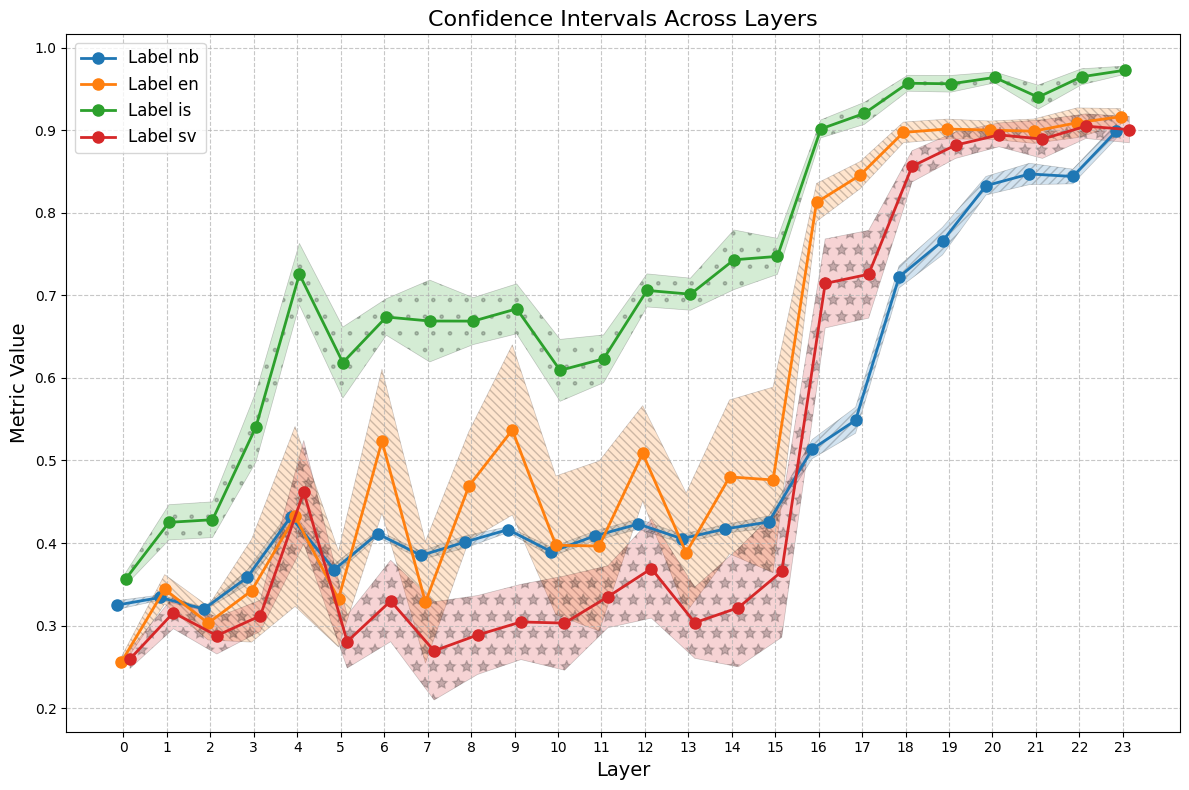

In [12]:
plot_confidence_intervals(d,meta_data)